# Avoid throwing away real cells!!

In [ ]:
%pip install scanpy matplotlib-venn harmonypy liedenalg

In [1]:
#single-cell/RNA modules
import scanpy as sc
import scanpy.external as sce
import doubletdetection

#basic modules
import os
import random
from tqdm import tqdm

#stats/data modules}
import pandas as pd
import numpy as np
from scipy.stats import median_abs_deviation as mad


In [2]:
#90% of warnings are useless, but you may want to not run this chunk if you are not proficient
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

### The dataset

Intranasal infection with H1N1 in **mice**. **Day 0** is uninfected along with **5, 7, 10, and 14 days post-infection.**  

**GSE148499**

Please cite PMID: 35511435 if you use this data in your work!

In [3]:
#file_paths = ['adatas/' +x for x in os.listdir('adatas') if 'SMALL' in x] #SMALL is subset data
file_paths = ['adatas/' + x for x in os.listdir('adatas') if 'SMALL' not in x]

In [4]:
file_paths

['adatas/D0_filtered.h5ad',
 'adatas/D10_filtered.h5ad',
 'adatas/D5_filtered.h5ad',
 'adatas/D7_filtered.h5ad',
 'adatas/D14_filtered.h5ad']

In [5]:
'''
Load anndata and make a new obs column with sample metadata
'''
def load(path):
    adata = sc.read_h5ad(path)

    adata.obs['Sample'] = path.split('/')[1].split('_')[0] #note that this is specific my file names
    
    return adata

In [6]:
adatas = [load(x) for x in file_paths] #list comprehension is one of the easiest ways to work with multiple objects

In [7]:
adatas

[AnnData object with n_obs × n_vars = 8363 × 18794
     obs: 'n_genes', 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells',
 AnnData object with n_obs × n_vars = 11530 × 18094
     obs: 'n_genes', 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells',
 AnnData object with n_obs × n_vars = 10506 × 17752
     obs: 'n_genes', 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells',
 AnnData object with n_obs × n_vars = 12033 × 18050
     obs: 'n_genes', 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells',
 AnnData object with n_obs × n_vars = 7859 × 18813
     obs: 'n_genes', 'Sample'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells']

## QC  

In [8]:
'''
Adds various QC metrics to an anndata object
'''
def qc(adata):
    adata.var["mt"] = adata.var_names.str.startswith("mt-") #make sure capitalization is correct!
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)
    
    return adata

In [9]:
adatas = [qc(ad) for ad in adatas]

## Filtering/ preprocessing
Based on QC metrics we now need to annoate low quality cells.  


In [10]:
'''
Automated/objective way to remove outliers based on median absolute deviations

Returns true if a given cell is a MAD outlier
'''
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))

In [11]:
'''
Removes outlier cells from an individual anndata object
'''
def pp(adata):
    sc.pp.filter_cells(adata, min_genes = 200) #real cells really shouldn't have this few genes. Unless data very sparse

    #here we are summing bool. ie. False + False = False, True + True = True, False + True = True
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
        
    adata.obs['Outlier'] = bool_vector #annotating but not removing !!!!!!!!!!!!!!!!!!!!!!

    adata = adata[adata.obs.pct_counts_mt < 25] #just in case any made it, typically 25% is very high

    return adata

In [12]:
adatas = [pp(ad) for ad in adatas]

In [13]:
adatas

[View of AnnData object with n_obs × n_vars = 8045 × 18794
     obs: 'n_genes', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Outlier'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 View of AnnData object with n_obs × n_vars = 11300 × 18094
     obs: 'n_genes', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Outlier'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 View of AnnData object with n_obs × n_vars = 10400 × 17752
     obs: 'n_

In [14]:
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1)

'''
Labels but does not remove doublets in a single cell object

Uses two methods: doubletdecection and scrublet
'''
def dd(adata): #two methods!
    sc.pp.scrublet(adata, expected_doublet_rate = 0.1) #default is 0.05

    doublets = clf.fit(adata.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()
    adata.obs["clf_doublet"] = doublets
    adata.obs["clf_score"] = doublet_score

    #to filter
    #adata = adata[~((adata.obs.predicted_doublet) | (adata.obs.clf_doublet == 1))]
    
    return adata

In [15]:
adatas = [dd(ad) for ad in adatas]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## Integration

Here I am using harmony. Simple and fast to use with sce.external. Each method will need slightly different preparation at this point. e.g., scvi-tools will use raw counts

In [16]:
'''
Change obs names and save raw counts
'''
def prep_int(adata):
    adata.obs.index = adata.obs.index + '_' + adata.obs.Sample #making obs_names unique based on name
    #adata.layers['counts'] = adata.X.copy() #usually save raw counts
    return adata

In [17]:
adatas = [prep_int(ad) for ad in adatas]

In [18]:
adata = sc.concat(adatas, join='outer') #outer to keep all genes in all objects

In [19]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, batch_key = 'Sample', subset=False) #we don't want to affect counts layer
sc.pp.scale(adata)
sc.pp.pca(adata, use_highly_variable=True) #True since we didnt subset

In [20]:
sce.pp.harmony_integrate(adata, key = 'Sample')

2024-11-19 19:52:23,600 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-19 19:52:26,776 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-19 19:52:26,903 - harmonypy - INFO - Iteration 1 of 10
2024-11-19 19:52:35,870 - harmonypy - INFO - Iteration 2 of 10
2024-11-19 19:52:43,463 - harmonypy - INFO - Iteration 3 of 10
2024-11-19 19:52:50,513 - harmonypy - INFO - Iteration 4 of 10
2024-11-19 19:52:57,061 - harmonypy - INFO - Iteration 5 of 10
2024-11-19 19:53:02,725 - harmonypy - INFO - Iteration 6 of 10
2024-11-19 19:53:06,605 - harmonypy - INFO - Iteration 7 of 10
2024-11-19 19:53:10,744 - harmonypy - INFO - Iteration 8 of 10
2024-11-19 19:53:14,595 - harmonypy - INFO - Iteration 9 of 10
2024-11-19 19:53:18,207 - harmonypy - INFO - Iteration 10 of 10
2024-11-19 19:53:22,830 - harmonypy - INFO - Converged after 10 iterations


In [21]:
sc.pp.neighbors(adata, use_rep = "X_pca_harmony") #all we really did was make a new embedding and now we are using it

sc.tl.umap(adata)

In [22]:
adata.obs['Doublet'] = (adata.obs.clf_doublet == 1) | (adata.obs.predicted_doublet) #annotating not removing

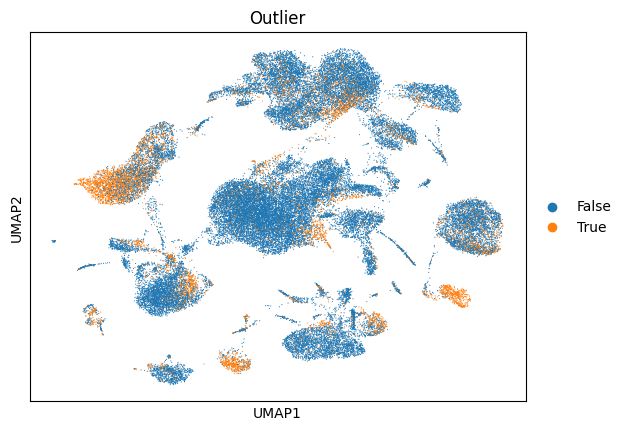

In [23]:
sc.pl.umap(adata, color = 'Outlier')

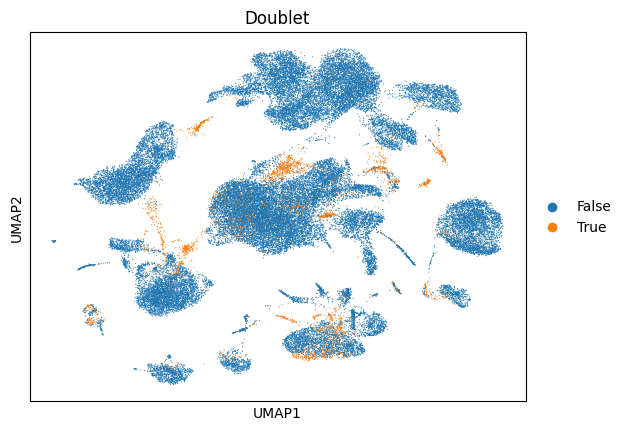

In [24]:
sc.pl.umap(adata, color = 'Doublet')

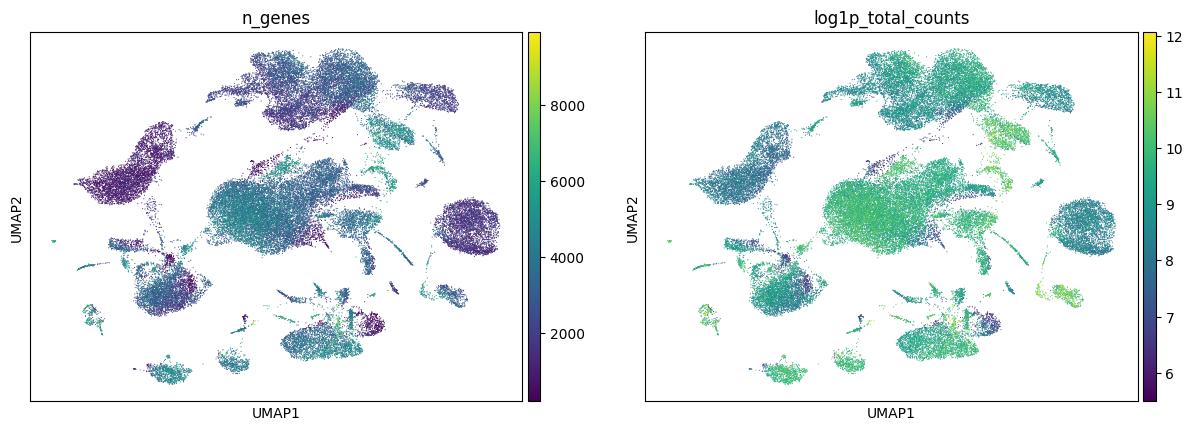

In [25]:
sc.pl.umap(adata, color = ['n_genes', 'log1p_total_counts'])

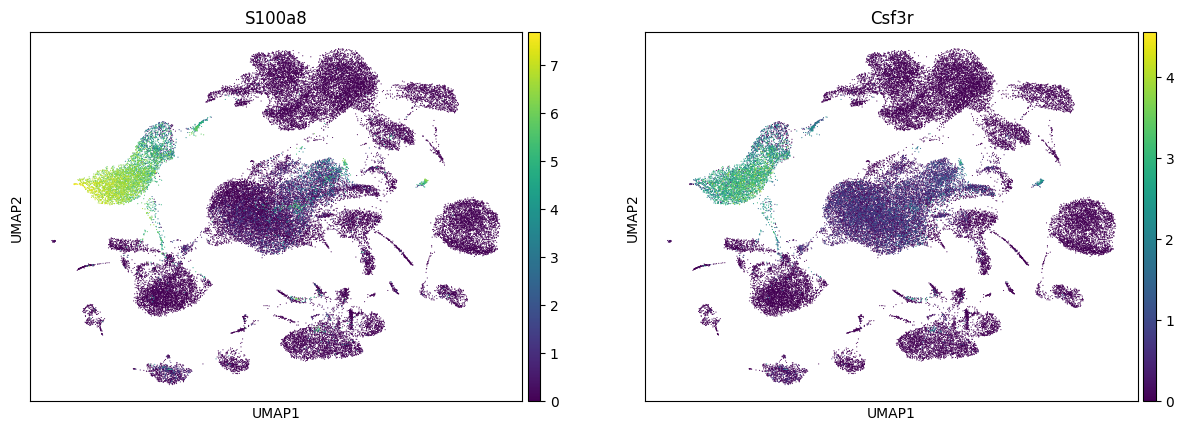

In [26]:
#S100A8
#CSF3R
sc.pl.umap(adata, color = ['S100a8', 'Csf3r'])

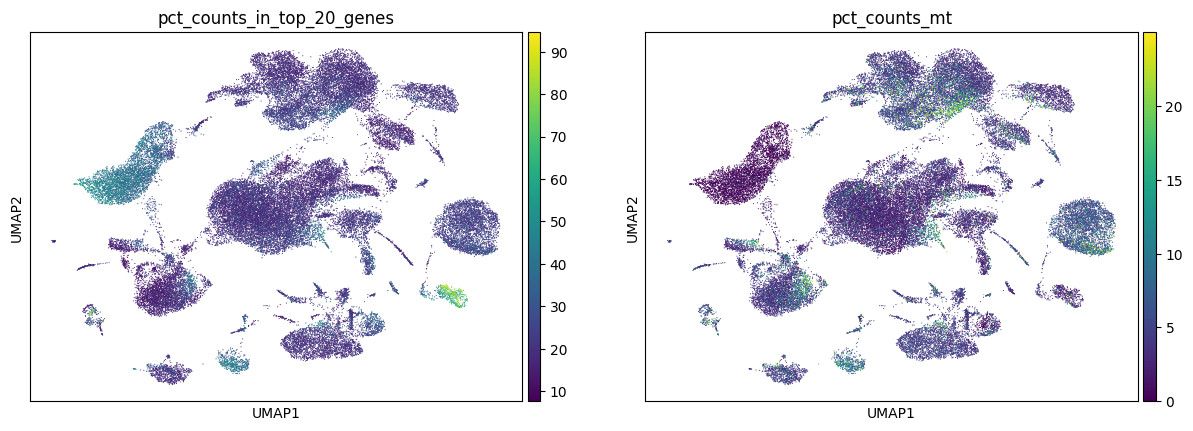

In [27]:
sc.pl.umap(adata, color = ['pct_counts_in_top_20_genes', 'pct_counts_mt'])

In [28]:
sc.tl.leiden(adata, resolution = 0.5)

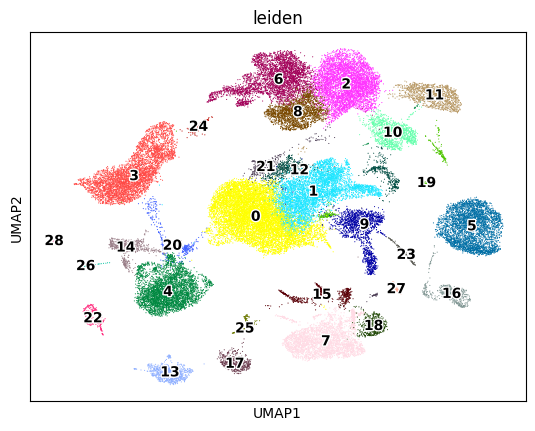

In [29]:
sc.pl.umap(adata, color = ['leiden'], legend_loc = 'on data', legend_fontoutline = 2)

In [30]:
adata.obs.groupby('leiden')['Outlier'].mean().sort_values()

leiden
28    0.037037
12    0.044525
1     0.059410
9     0.059975
19    0.069069
0     0.071139
20    0.071672
7     0.073534
11    0.090598
26    0.094828
13    0.103614
15    0.112903
23    0.113514
10    0.121702
6     0.126361
8     0.132784
4     0.154134
24    0.157233
2     0.171623
14    0.172303
27    0.186813
5     0.196424
25    0.328671
21    0.395904
18    0.418367
22    0.441767
3     0.569826
17    0.774900
16    0.851718
Name: Outlier, dtype: float64

In [31]:
adata.obs.groupby('leiden')['Doublet'].mean().sort_values()

leiden
8     0.005661
3     0.008471
18    0.010204
6     0.015186
11    0.017094
9     0.018939
10    0.023830
5     0.026264
2     0.031648
28    0.037037
13    0.038554
4     0.044217
21    0.054608
1     0.058561
26    0.060345
23    0.064865
0     0.065229
17    0.067729
15    0.068100
14    0.077295
25    0.083916
16    0.130199
7     0.275500
27    0.373626
22    0.425703
12    0.820698
19    0.879880
24    0.962264
20    0.965870
Name: Doublet, dtype: float64

In [32]:
sc.tl.rank_genes_groups(adata, groupby='leiden')

/home/mark/miniconda3/envs/sc2024/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/mark/miniconda3/envs/sc2024/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/mark/miniconda3/envs/sc2024/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:434: PerformanceWa

In [33]:
marks = sc.get.rank_genes_groups_df(adata, group=None)

In [35]:
marks[marks.group == '17'] #.head(20).names.tolist()

,group,names,scores,logfoldchanges,pvals,pvals_adj
344488,17,Sftpb,205.252747,13.991822,0.0,0.0
344489,17,Sftpc,168.719116,18.197088,0.0,0.0
344490,17,Sftpa1,164.377838,15.501966,0.0,0.0
344491,17,Sftpd,163.988083,12.704466,0.0,0.0
344492,17,Wfdc2,158.831329,10.153563,0.0,0.0
...,...,...,...,...,...,...
364747,17,Fermt3,-100.114471,-5.241947,0.0,0.0
364748,17,Arhgdib,-100.901962,-5.393338,0.0,0.0
364749,17,Hcst,-101.781151,-5.604590,0.0,0.0
364750,17,Coro1a,-103.036522,-5.762125,0.0,0.0


In [36]:
outlier_whitelist = adata.obs[adata.obs.leiden.isin(['3', '16', '17'])].index

In [37]:
doublet_whitelist = []

In [38]:
adata = adata[(~adata.obs['Outlier']) | adata.obs.index.isin(outlier_whitelist)].copy()

In [39]:
adata = adata[(~adata.obs['Doublet']) | adata.obs.index.isin(doublet_whitelist)].copy()

In [40]:
adata

AnnData object with n_obs × n_vars = 40000 × 20264
    obs: 'n_genes', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'Outlier', 'doublet_score', 'predicted_doublet', 'clf_doublet', 'clf_score', 'Doublet', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'Outlier_colors', 'Doublet_colors', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [41]:
adata = adata.raw.to_adata()

In [42]:
adata.raw = adata #back to norm/transformed data

In [43]:
sc.pp.highly_variable_genes(adata, batch_key = 'Sample', subset=False) #we don't want to affect counts layer
sc.pp.scale(adata)
sc.pp.pca(adata, use_highly_variable=True) #True since we didnt subset
sce.pp.harmony_integrate(adata, key = 'Sample')

2024-11-19 20:03:29,405 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-19 20:03:31,728 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-19 20:03:31,780 - harmonypy - INFO - Iteration 1 of 10
2024-11-19 20:03:36,348 - harmonypy - INFO - Iteration 2 of 10
2024-11-19 20:03:41,738 - harmonypy - INFO - Iteration 3 of 10
2024-11-19 20:03:46,461 - harmonypy - INFO - Iteration 4 of 10
2024-11-19 20:03:50,768 - harmonypy - INFO - Iteration 5 of 10
2024-11-19 20:03:55,412 - harmonypy - INFO - Iteration 6 of 10
2024-11-19 20:03:58,202 - harmonypy - INFO - Converged after 6 iterations


In [44]:
sc.pp.neighbors(adata, use_rep = "X_pca_harmony") #all we really did was make a new embedding and now we are using it
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

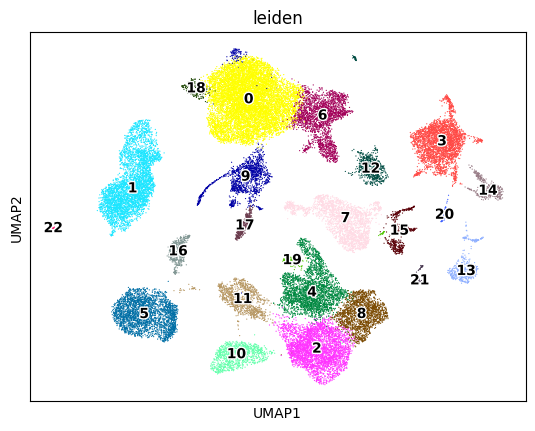

In [45]:
sc.pl.umap(adata, color = ['leiden'], legend_loc = 'on data', legend_fontoutline = 2)